In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from os.path import normpath
from operator import itemgetter
from functools import partial

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import joblib
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    PowerTransformer,
    QuantileTransformer,
    FunctionTransformer,
    Normalizer,
    Binarizer,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    RidgeClassifier,
    RidgeClassifierCV,
    PassiveAggressiveClassifier,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    HashingVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    RepeatedStratifiedKFold,
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import (
    make_column_transformer,
    make_column_selector,
    ColumnTransformer,
)
from gensim.parsing.preprocessing import STOPWORDS, preprocess_string

<IPython.core.display.Javascript object>

In [3]:
# Import my modules
from tools import cleaning, plotting, language as lang, utils
from tools.modeling.vectorizers import Doc2Vectorizer
from tools.modeling.transformers import ArrayForcer
from tools.modeling.wrappers import PandasWrapper
from tools.modeling.classification import diagnostics as diag
from tools.modeling.selection import sweep, load_results

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# RandomState for reproducibility
rando = np.random.RandomState(9547)

<IPython.core.display.Javascript object>

# Overview of Dataset

In [4]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Looks like one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing this dataset. I'm going to rename those before I do anything else.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [6]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

,text,object_of_emotion,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [7]:
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative emotion
iPad or iPhone App,Positive emotion
iPad,No emotion toward brand or product
Google,I can't tell
Android,
Apple,
Android App,
Other Google product or service,
Other Apple product or service,


<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [8]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [9]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative
iOS App,Positive
iPad,Neutral
Google,Uncertain
Android,
Apple,
Android App,
Other Google Product,
Other Apple Product,


<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':"'emotion' Value Counts"}, xlabel='Count'>

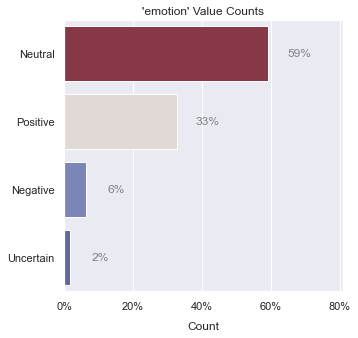

<IPython.core.display.Javascript object>

In [10]:
plotting.countplot(df["emotion"], normalize=True)

<AxesSubplot:title={'center':"'emotion' Value Counts"}, xlabel='Count'>

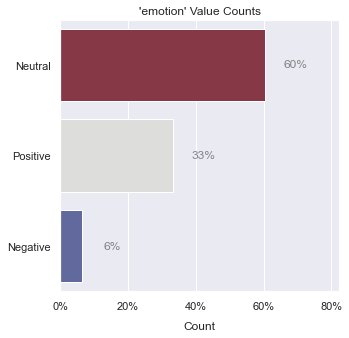

<IPython.core.display.Javascript object>

In [11]:
# Remove 'Uncertain' category
df.emotion.cat.remove_categories("Uncertain", inplace=True)
plotting.countplot(df.emotion, normalize=True)

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [12]:
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5802,63.81,9,0.10,22,0.24
emotion,156,1.72,3,0.03,22,0.24
text,1,0.01,9065,99.69,22,0.24


<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [13]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5654,63.27,9,0.10,22,0.25
text,0,0.00,8909,99.70,22,0.25
emotion,0,0.00,3,0.03,22,0.25


<IPython.core.display.Javascript object>

In [14]:
null_rows = cleaning.null_rows(df)
lang.readable_sample(null_rows["text"], random_state=rando)

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 5140 | RT @mention @mention New iPad Apps For Speech Therapy And Communication Are Showcased At #SXSW Conference {link} #sxswi #hcsm #sxswh    |
|  509 | Please RT Follow the next big #college social network @mention chance to win an #iPad at 7,000 followers #socialmedia #SXSW             |
| 4916 | millions of iPhone cases at #SXSW trade show but can any of them double as shuffleboard wax sprinklers? I think not. #fail (CC @mention |
| 6384 | RT @mention not launching any products at #SXSW but we're doing plenty else.  {link}                                                    |
|  790 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw&quot;                                             |
| 8793 | Google giving Social another go? {link} Google Circles, let's see what the guys at #SXSW make of it                                     |
| 8452 | @mention The unofficial #SXSW torrents are a great way to hear what you can expect this year {link}                                     |
| 3645 | U gotta fight for yr right to party &amp; to privacy ACLU/google #sxsw #partylikeits1986                                                |
|   61 | #futuremf @mention {link} spec for recipes on the web, now in google search: {link}  #sxsw                                              |
| 4081 | Hope people ask the tough questions. RT @mention Reminder: Android and Chrome TTS talk @mention 1 PM today!  {link}  #sxsw              |

<IPython.core.display.Javascript object>

Looks like some of the NaN values don't line up with the 'Neutral' category.

In [15]:
emotion_without_object = null_rows.loc[null_rows.emotion != "Neutral"]

# Delete variable
del null_rows

display(emotion_without_object.head(), emotion_without_object.shape)

,text,object_of_emotion,emotion
46,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive


(357, 3)

<IPython.core.display.Javascript object>

In [16]:
lang.readable_sample(
    emotion_without_object.groupby("emotion").get_group("Positive").text,
    random_state=rando,
)

|      | text                                                                                                                                                  |
|-----:|:------------------------------------------------------------------------------------------------------------------------------------------------------|
| 3353 | Whoohoo! Got it! ;) RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW (cont) {link}                            |
| 3928 | dancing with myself at google 80s party.... ain't that the truth! need my girl @mention up in this joint #SXSW {link}                                 |
|  783 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw rt @mention via @mention                                        |
| 1365 | @mention - re: &quot;lack of #SXSW newsworthy announcements&quot;. Unless you count Google Circles. :) #googlecircles                                 |
| 5307 | RT @mention #SXSW News: Apple is getting into the music business? New device called an &quot;iPod&quot;. Like a compact disc player without the disk. |
| 2447 | Near Field Communication already here on android phones. #SXSW #bemyneighbor                                                                          |
| 7530 | #spiltbeer consequences of drunk techies #sxsw let's see what android has to offer compared to this.                                                  |
| 5965 | RT @mention Having fun w/ @mention new Check-In's feature on iPhone | See @mention latest article &quot;Roll your own 4square&quot; {link} #SXSW      |
| 3442 | Back in the big apple!  Need to wean off my new foursquare addiction thanks to #sxsw and @mention Do people really care where I am? Nah               |
| 3780 | FYI @mention is working on an iPhone app, looking to release it this summer, hopefully. #SXSW #flipboard                                              |

<IPython.core.display.Javascript object>

In [17]:
# Create regex for finding each brand
re_apple = r"ipad\d?\s*app|ipad\d?|iphone\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find all brand/product name occurrences for each brand
findings = lang.locate_patterns(
    re_apple,
    re_google,
    docs=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

google         122
ipad            98
apple           76
iphone          57
ipad2           26
android         19
iphone app       8
ipad app         4
ipad1            1
android app      1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [18]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

,original,match,score
5401,ipad2,iPad,89
3179,ipad2,iPad,89
8149,ipad2,iPad,89
6309,ipad2,iPad,89
3710,ipad2,iPad,89
...,...,...,...
3224,ipad,iPad,100
3179,ipad,iPad,100
3134,google,Google,100
3055,ipad,iPad,100


<IPython.core.display.Javascript object>

In [19]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=rando)

,text,object_of_emotion,emotion
598,CNNMoney: Got a craving? #SXSW minds created a...,iPhone,Positive
5401,RT @mention Anyone at #sxsw want to make a qui...,iPad,Positive
5212,"RT @mention #Apple saves #SXSW, set to open po...",Apple,Positive
639,Catch 22��_ I mean iPad 2 at #SXSW - {link} #a...,iPad,Positive
5586,"RT @mention Buying iPad2? Turn in ur iPad1, Ap...",iPad,Positive
8898,@mention What's the wait time lookin like? The...,Apple,Positive
6371,RT @mention Nice! @mention just told me @menti...,iPad,Positive
7680,Google (tries again) to launch a new social ne...,Google,Negative
1813,3rd time a charm? All about privacy! RT @menti...,Google,Positive
1284,Trying to update software (4.0) on iPhone to d...,iPhone,Negative


<IPython.core.display.Javascript object>

In [20]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

In [21]:
object_without_emotion = df.loc[
    (df.emotion == "Neutral") & df.object_of_emotion.notnull()
]
display(object_without_emotion.head(), object_without_emotion.shape)

,text,object_of_emotion,emotion
63,#Smile RT @mention I think Apple's &quot;pop-u...,Apple,Neutral
265,The #SXSW Apple &quot;pop-up&quot; store was n...,Apple,Neutral
317,I arrived at #sxsw and my @mention issue hasn'...,iOS App,Neutral
558,haha. the google &quot;Party like it's 1986&qu...,Google,Neutral
588,Diller on Google TV: &quot;The first product w...,Other Google Product,Neutral


(91, 3)

<IPython.core.display.Javascript object>

Tweet 6517 seems clearly negative to me, and 7137 seems kind of sardonic. 2666 seems weakly positive. 8647, 5696, 7521, 668, and 265 don't seem to express an emotion toward a brand or product. Since most of them seem neutral to me, and that's consistent with their 'Neutral' label, I'm going to keep them that way.

In [22]:
lang.readable_sample(object_without_emotion["text"], random_state=rando)

|      | text                                                                                                                                                       |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| 6127 | RT @mention In iPad Design Headaches: Take Two Tablets, Call Me in the AM panel - excited to hear @mention live! #sxsw                                     |
| 8271 | Google Hot Pot - what the whattt pot....#SXSW                                                                                                              |
| 1628 | @mention @mention Similarily, Tweetcaster for Android lets you zip tweets w annoying hash tags, like #sxsw                                                 |
| 6517 | RT @mention RT @mention Best thing I've heard this weekend at #SXSW &quot;I gave my iPad 2 money to #Japan relief. I don't need an iPad 2.&quot; (@mention |
| 8849 | We can't wait to give an iPad to someone at #sxsw. Want in? Just head to www.pep.jobs/upc to enter. (must be present to win)                               |
| 3011 | #iPad interface/controls should be at the top, mobile controls at the bottom. #tapworthy #sxsw                                                             |
|  787 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw�۝ @mention                                                           |
| 4826 | Talking to a 15 year old iPhone developer genius who came to SXSW with his proud dad. #SXSW @mention BD Riley's Irish Pub {link}                           |
| 1276 | Apple has two Austin-area retail locations but in anticipation of all the gadget ...  #ipad #sxsw #gadgets {link}                                          |
| 7173 | ipad is not a game changer just a new game, its a about multiplicity and options not either or, but someone has to p[ay for content! #sxsw                 |

<IPython.core.display.Javascript object>

In [23]:
# Set object to null where emotion is neutral
df.loc[object_without_emotion.index, "object_of_emotion"] = np.nan

# Ensure that 'Neutral' rows line up with 'NaN' rows
(df["emotion"] == "Neutral").equals(df["object_of_emotion"].isnull())

True

<IPython.core.display.Javascript object>

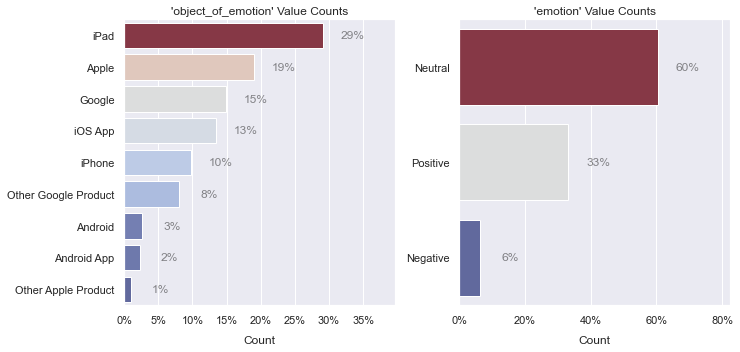

<IPython.core.display.Javascript object>

In [24]:
fig = plotting.countplot(df.select_dtypes("category"), normalize=1)

There are $22$ duplicate rows, but I'm not going to remove them yet. I'll dynamically remove duplicates as part of my preprocessing pipeline so I can catch as many as possible.

In [25]:
cleaning.dup_rows(df).sort_values("text")

,text,object_of_emotion,emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
776,Google to Launch Major New Social Network Call...,NaN,Neutral
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,Neutral
8747,Need to buy an iPad2 while I'm in Austin at #s...,iPad,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iOS App,Positive
5884,RT @mention Google to Launch Major New Social ...,NaN,Neutral
5882,RT @mention Google to Launch Major New Social ...,NaN,Neutral


<IPython.core.display.Javascript object>

In [26]:
funcs = [
    lang.lowercase,
    lang.strip_short,
    partial(lang.strip_punct, exclude="@#!?"),
    lang.strip_multiwhite,
    lang.strip_numeric,
    lang.strip_non_alphanum,
    lang.split_alphanum,
    lang.uni2ascii,
    lang.stem_text,
    lang.strip_handles,
    lang.limit_repeats,
    lang.wordnet_lemmatize,
    lang.stem_text,
]

func_names = utils.get_func_name(funcs)

funcs = [FunctionTransformer(func=x) for x in funcs]

funcs = pd.Series(dict(zip(func_names, funcs)))
funcs

lowercase             FunctionTransformer(func=<function lowercase a...
strip_short           FunctionTransformer(func=<function strip_short...
strip_punct           FunctionTransformer(func=functools.partial(<fu...
strip_multiwhite      FunctionTransformer(func=<function strip_multi...
strip_numeric         FunctionTransformer(func=<function strip_numer...
strip_non_alphanum    FunctionTransformer(func=<function strip_non_a...
split_alphanum        FunctionTransformer(func=<function split_alpha...
uni2ascii             FunctionTransformer(func=<function uni2ascii a...
stem_text             FunctionTransformer(func=<function stem_text a...
strip_handles         FunctionTransformer(func=<function strip_handl...
limit_repeats         FunctionTransformer(func=<function limit_repea...
wordnet_lemmatize     FunctionTransformer(func=<function wordnet_lem...
dtype: object

<IPython.core.display.Javascript object>

In [27]:
filts = [
    "lowercase",
    "uni2ascii",
    "limit_repeats",
    "strip_punct",
    "split_alphanum",
    "strip_short",
    "strip_multiwhite",
]

filts = list(zip(filts, funcs.loc[filts].to_list()))
filts = PandasWrapper(Pipeline(filts))
filts.fit_transform(df.text)

0       @wesley have iphone after hrs tweeting #rise a...
1       @jessedee know about @fludapp awesome ipad iph...
2       @swonderlin can not wait for #ipad also they s...
3       @sxsw hope this year festival isn crashy this ...
4       @sxtxstate great stuff fri #sxsw marissa mayer...
                              ...                        
9088                           ipad everywhere #sxsw link
9089    wave buzz @mention interrupt your regularly sc...
9090    google zeiger physician never reported potenti...
9091    some verizon iphone customers complained their...
9092       @mention google tests check offers@ #sxsw link
Name: text, Length: 8912, dtype: object

<IPython.core.display.Javascript object>

In [28]:
df["clean_text"] = filts.fit_transform(df.text)
df.head()

,text,object_of_emotion,emotion,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,@wesley have iphone after hrs tweeting #rise a...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iOS App,Positive,@jessedee know about @fludapp awesome ipad iph...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,@swonderlin can not wait for #ipad also they s...
3,@sxsw I hope this year's festival isn't as cra...,iOS App,Negative,@sxsw hope this year festival isn crashy this ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,@sxtxstate great stuff fri #sxsw marissa mayer...


<IPython.core.display.Javascript object>

In [29]:
re_brand = fr"{re_apple}|{re_google}"
regex_brands = lang.locate_patterns(re_brand, docs=df.clean_text)
regex_brands = utils.implode(regex_brands).reindex_like(df)
df["brand_terms"] = regex_brands
del regex_brands
df["brand_terms"].head()

0              [iphone]
1    [ipad, iphone app]
2                [ipad]
3          [iphone app]
4              [google]
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

In [30]:
df["tokens"] = df.clean_text.map(nltk.casual_tokenize)
df["tokens"].head()

0    [@wesley, have, iphone, after, hrs, tweeting, ...
1    [@jessedee, know, about, @fludapp, awesome, ip...
2    [@swonderlin, can, not, wait, for, #ipad, also...
3    [@sxsw, hope, this, year, festival, isn, crash...
4    [@sxtxstate, great, stuff, fri, #sxsw, marissa...
Name: tokens, dtype: object

<IPython.core.display.Javascript object>

In [31]:
df["tagged"] = df.tokens.map(nltk.pos_tag)
df["tagged"].head()

0    [(@wesley, NNS), (have, VBP), (iphone, VBN), (...
1    [(@jessedee, NN), (know, VBP), (about, IN), (@...
2    [(@swonderlin, NNS), (can, MD), (not, RB), (wa...
3    [(@sxsw, RB), (hope, NN), (this, DT), (year, N...
4    [(@sxtxstate, JJ), (great, JJ), (stuff, NN), (...
Name: tagged, dtype: object

<IPython.core.display.Javascript object>

In [32]:
df["pos_tags"] = utils.implode(df["tagged"].explode().map(itemgetter(1)))
df["pos_tags"].head()

0    [NNS, VBP, VBN, IN, NN, VBG, NN, NN, VBD, JJ, ...
1    [NN, VBP, IN, NNP, JJ, NN, NN, NN, IN, PRP, JJ...
2    [NNS, MD, RB, VB, IN, NN, RB, PRP, MD, NN, PRP...
3     [RB, NN, DT, NN, NN, NN, NN, DT, NN, NN, NN, NN]
4    [JJ, JJ, NN, NN, NNP, NN, NN, NN, NN, RB, JJ, ...
Name: pos_tags, dtype: object

<IPython.core.display.Javascript object>

# Exploration

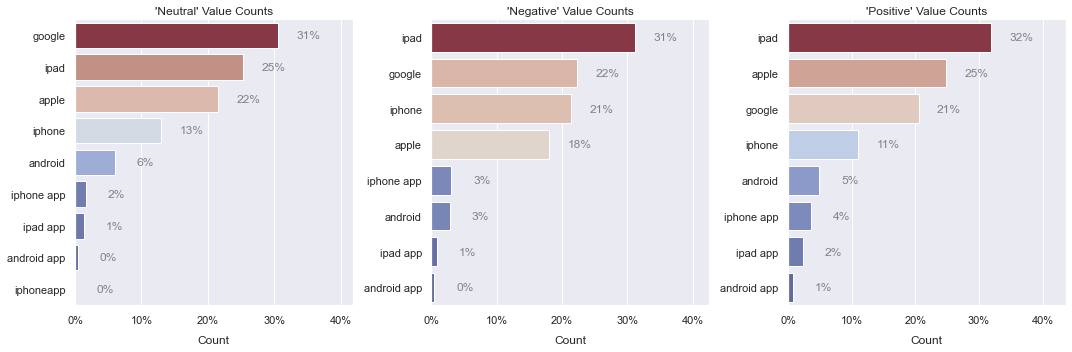

<IPython.core.display.Javascript object>

In [33]:
fig = plotting.countplot(
    df.explode("brand_terms").groupby("emotion")["brand_terms"],
    normalize=True,
)

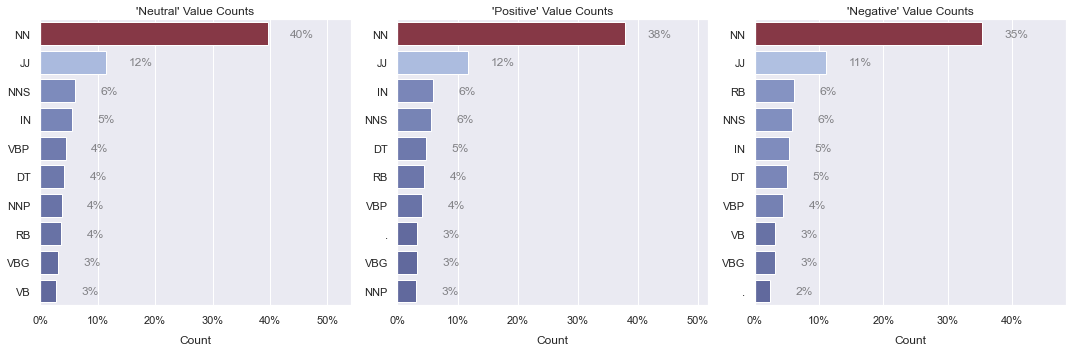

<IPython.core.display.Javascript object>

In [34]:
grouped = df.explode("pos_tags").groupby("emotion")["pos_tags"]

fig = plotting.countplot(grouped, normalize=True, topn=10)

In [35]:
# Try POS filtering
# Try tfidf vectorizing with just POS tags

<IPython.core.display.Javascript object>

In [36]:
stop_words = list(STOPWORDS) + ["sxsw", "#sxsw", "quot", "link"]
stop_words.sort()
print(stop_words)

['#sxsw', 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'fort

<IPython.core.display.Javascript object>

In [37]:
brand_docs = (
    pd.Series(df.groupby(["emotion", "object_of_emotion"]).groups)
    .map(lambda x: df.loc[x, "clean_text"])
    .map(lambda x: " ".join(x))
)

brand_docs = brand_docs.drop(index=np.nan, level=0)
brand_docs

Negative  Android                 they took away the lego pit but replaced with ...
          Android App             beware the android #sxsw app for schedules com...
          Apple                   again? @mention line the apple store insane #s...
          Google                  @mention false alarm google circles not coming...
          Other Apple Product     @mention meant itunes doesn work for don run a...
          Other Google Product    @mention google launch major new social networ...
          iOS App                 @sxsw hope this year festival isn crashy this ...
          iPad                    attending @mention ipad design headaches #sxsw...
          iPhone                  @wesley have iphone after hrs tweeting #rise a...
Neutral   NaN                     @teachntech new ipad apps for #speechtherapy a...
Positive  Android                 #sxsw just starting #ctia around the corner an...
          Android App             find amp start impromptu parties #sxsw wit

<IPython.core.display.Javascript object>

In [38]:
tfidf = TfidfVectorizer(
    tokenizer=partial(nltk.casual_tokenize, strip_handles=True),
    stop_words=stop_words,
    max_features=None,
    ngram_range=(1, 3),
    norm="l2",
)
brand_vecs = tfidf.fit_transform(brand_docs.values)
brand_vecs = lang.frame_doc_vecs(
    brand_vecs,
    tfidf.vocabulary_,
    brand_docs.index,
).T
brand_vecs

Negative                                  \
                          Android Android App     Apple    Google   
!                         0.04388    0.025603  0.054796  0.062841   
! !                       0.00000    0.000000  0.005163  0.010996   
! ! !                     0.00000    0.000000  0.000000  0.005793   
! ! #angrybirds           0.00000    0.000000  0.000000  0.000000   
! ! #apple                0.00000    0.000000  0.000000  0.000000   
...                           ...         ...       ...       ...   
zynga facebook            0.00000    0.000000  0.000000  0.000000   
zynga facebook microsoft  0.00000    0.000000  0.000000  0.000000   
zzzs                      0.00000    0.000000  0.000000  0.000000   
zzzs iphone               0.00000    0.000000  0.000000  0.000000   
zzzs iphone battery       0.00000    0.000000  0.000000  0.000000   

                                                                             \
                         Other Apple Product Other Google Product   iOS App   
!                                        0.0             0.041581  0.073591   
! !                                      0.0             0.016977  0.022535   
! ! !                                    0.0             0.008943  0.007914   
! ! #angrybirds                          0.0             0.000000  0.000000   
! ! #apple                               0.0             0.000000  0.000000   
...                                      ...                  ...       ...   
zynga facebook                           0.0             0.000000  0.000000   
zynga facebook microsoft                 0.0             0.000000  0.000000   
zzzs                                     0.0             0.000000  0.000000   
zzzs iphone                              0.0             0.000000  0.000000   
zzzs iphone battery                      0.0             0.000000  0.000000   

                                               Neutral  Positive              \
                              iPad    iPhone       NaN   Android Android App   
!                         0.040762  0.135289  0.171880  0.207318    0.243020   
! !                       0.000000  0.011047  0.013888  0.027452    0.029766   
! ! !                     0.000000  0.005820  0.004413  0.007231    0.015681   
! ! #angrybirds           0.000000  0.000000  0.000565  0.000000    0.000000   
! ! #apple                0.000000  0.000000  0.000000  0.000000    0.000000   
...                            ...       ...       ...       ...         ...   
zynga facebook            0.000000  0.000000  0.002262  0.000000    0.000000   
zynga facebook microsoft  0.000000  0.000000  0.002262  0.000000    0.000000   
zzzs                      0.000000  0.014167  0.000000  0.000000    0.000000   
zzzs iphone               0.000000  0.014167  0.000000  0.000000    0.000000   
zzzs iphone battery       0.000000  0.014167  0.000000  0.000000    0.000000   

                                                                  \
                             Apple    Google Other Apple Product   
!                         0.132520  0.193603            0.215399   
! !                       0.010887  0.041427            0.000000   
! ! !                     0.003128  0.015051            0.000000   
! ! #angrybirds           0.000000  0.000000            0.000000   
! ! #apple                0.000000  0.000000            0.000000   
...                            ...       ...                 ...   
zynga facebook            0.000000  0.000000            0.000000   
zynga facebook microsoft  0.000000  0.000000            0.000000   
zzzs                      0.000000  0.000000            0.000000   
zzzs iphone               0.000000  0.000000            0.000000   
zzzs iphone battery       0.000000  0.000000            0.000000   

                                                                             
                         Other Google Product   iOS App      iPad    iPhone  
!                

<IPython.core.display.Javascript object>

In [39]:
brand_vecs = brand_vecs.sort_index(1)
brand_vecs

Negative                                  \
                          Android Android App     Apple    Google   
!                         0.04388    0.025603  0.054796  0.062841   
! !                       0.00000    0.000000  0.005163  0.010996   
! ! !                     0.00000    0.000000  0.000000  0.005793   
! ! #angrybirds           0.00000    0.000000  0.000000  0.000000   
! ! #apple                0.00000    0.000000  0.000000  0.000000   
...                           ...         ...       ...       ...   
zynga facebook            0.00000    0.000000  0.000000  0.000000   
zynga facebook microsoft  0.00000    0.000000  0.000000  0.000000   
zzzs                      0.00000    0.000000  0.000000  0.000000   
zzzs iphone               0.00000    0.000000  0.000000  0.000000   
zzzs iphone battery       0.00000    0.000000  0.000000  0.000000   

                                                                             \
                         Other Apple Product Other Google Product   iOS App   
!                                        0.0             0.041581  0.073591   
! !                                      0.0             0.016977  0.022535   
! ! !                                    0.0             0.008943  0.007914   
! ! #angrybirds                          0.0             0.000000  0.000000   
! ! #apple                               0.0             0.000000  0.000000   
...                                      ...                  ...       ...   
zynga facebook                           0.0             0.000000  0.000000   
zynga facebook microsoft                 0.0             0.000000  0.000000   
zzzs                                     0.0             0.000000  0.000000   
zzzs iphone                              0.0             0.000000  0.000000   
zzzs iphone battery                      0.0             0.000000  0.000000   

                                               Neutral  Positive              \
                              iPad    iPhone       NaN   Android Android App   
!                         0.040762  0.135289  0.171880  0.207318    0.243020   
! !                       0.000000  0.011047  0.013888  0.027452    0.029766   
! ! !                     0.000000  0.005820  0.004413  0.007231    0.015681   
! ! #angrybirds           0.000000  0.000000  0.000565  0.000000    0.000000   
! ! #apple                0.000000  0.000000  0.000000  0.000000    0.000000   
...                            ...       ...       ...       ...         ...   
zynga facebook            0.000000  0.000000  0.002262  0.000000    0.000000   
zynga facebook microsoft  0.000000  0.000000  0.002262  0.000000    0.000000   
zzzs                      0.000000  0.014167  0.000000  0.000000    0.000000   
zzzs iphone               0.000000  0.014167  0.000000  0.000000    0.000000   
zzzs iphone battery       0.000000  0.014167  0.000000  0.000000    0.000000   

                                                                  \
                             Apple    Google Other Apple Product   
!                         0.132520  0.193603            0.215399   
! !                       0.010887  0.041427            0.000000   
! ! !                     0.003128  0.015051            0.000000   
! ! #angrybirds           0.000000  0.000000            0.000000   
! ! #apple                0.000000  0.000000            0.000000   
...                            ...       ...                 ...   
zynga facebook            0.000000  0.000000            0.000000   
zynga facebook microsoft  0.000000  0.000000            0.000000   
zzzs                      0.000000  0.000000            0.000000   
zzzs iphone               0.000000  0.000000            0.000000   
zzzs iphone battery       0.000000  0.000000            0.000000   

                                                                             
                         Other Google Product   iOS App      iPad    iPhone  
!                

<IPython.core.display.Javascript object>

In [40]:
# fig = plotting.wordcloud(brand_vecs.loc[:, "Negative"], cmap="Reds", random_state=rando)
# fig.savefig("negative.png")

<IPython.core.display.Javascript object>

In [41]:
# fig = plotting.wordcloud(
#     brand_vecs.loc[:, "Positive"], cmap="Greens", random_state=rando
# )
# fig.savefig("positive.png")

<IPython.core.display.Javascript object>

# Modeling

## Train-Test-Split

In [42]:
df["pos_tags"] = df["pos_tags"].str.join(" ")
df["pos_tags"].head()

0    NNS VBP VBN IN NN VBG NN NN VBD JJ . NN JJ NN ...
1    NN VBP IN NNP JJ NN NN NN IN PRP JJ NN IN PRP$...
2            NNS MD RB VB IN NN RB PRP MD NN PRP RP NN
3                  RB NN DT NN NN NN NN DT NN NN NN NN
4    JJ JJ NN NN NNP NN NN NN NN RB JJ NNS NNS VBP ...
Name: pos_tags, dtype: object

<IPython.core.display.Javascript object>

In [43]:
df.brand_terms = (
    df.brand_terms.map(lambda x: [y.replace(" ", "_") for y in x], "ignore")
    .str.join(" ")
    .fillna("")
)
df.brand_terms

0                iphone
1       ipad iphone_app
2                  ipad
3            iphone_app
4                google
             ...       
9088               ipad
9089             google
9090             google
9091             iphone
9092             google
Name: brand_terms, Length: 8912, dtype: object

<IPython.core.display.Javascript object>

In [44]:
cols = ["text", "pos_tags", "brand_terms"]
X = df.loc[:, cols].copy()
y = df.emotion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=rando,
    stratify=y,
    shuffle=True,
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6684, 3), (6684,), (2228, 3), (2228,))

<IPython.core.display.Javascript object>

## Baseline Dummy Model

In [45]:
dummy = DummyClassifier(strategy="stratified", random_state=rando)
dummy

DummyClassifier(random_state=RandomState(MT19937) at 0x21A87528240,
                strategy='stratified')

<IPython.core.display.Javascript object>

In [46]:
tfidf.set_params(
    preprocessor=None,
    max_features=None,
    tokenizer=nltk.casual_tokenize,
    token_pattern=None,
    ngram_range=(1, 1),
    stop_words=None,
)

tfidf_2 = TfidfVectorizer(tokenizer=lang.space_tokenize)

tfidf, tfidf_2

(TfidfVectorizer(token_pattern=None,
                 tokenizer=<function casual_tokenize at 0x0000021A83C1A4C0>),
 TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>))

<IPython.core.display.Javascript object>

In [47]:
col_xform = ColumnTransformer(
    [
        ("txt", tfidf, "text"),
        ("pos", clone(tfidf_2), "pos_tags"),
        ("bra", clone(tfidf_2), "brand_terms"),
    ],
    n_jobs=1,
)
col_xform

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 TfidfVectorizer(token_pattern=None,
                                                 tokenizer=<function casual_tokenize at 0x0000021A83C1A4C0>),
                                 'text'),
                                ('pos',
                                 TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                                 'pos_tags'),
                                ('bra',
                                 TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                                 'brand_terms')])

<IPython.core.display.Javascript object>

In [48]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("cls", dummy),
    ]
)
main_pipe

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(token_pattern=None,
                                                                  tokenizer=<function casual_tokenize at 0x0000021A83C1A4C0>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                                                  'brand_terms')])),
                ('cls',
                 DummyClassifier(random_state=RandomState(MT19937) at 0x21A87528

<IPython.core.display.Javascript object>

In [49]:
vecs = main_pipe[:1].fit_transform(X)
vecs

<8912x10634 sparse matrix of type '<class 'numpy.float64'>'
	with 252242 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.097,0.597,0.329,0.341,0.476,0.469,0.342
recall,0.106,0.573,0.348,0.342,0.469,,
f1-score,0.101,0.585,0.338,0.341,0.472,,
support,0.064,0.605,0.332,,,,


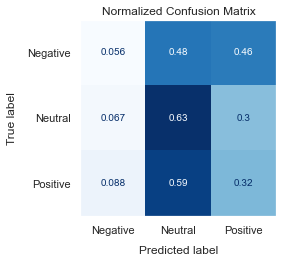

<IPython.core.display.Javascript object>

In [50]:
test_fit = partial(
    diag.test_fit,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
test_fit(main_pipe)

## Baseline Model

In [51]:
logit = LogisticRegression(
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1e4,
    verbose=0,
    random_state=rando,
)
logit

LogisticRegression(class_weight='balanced', max_iter=10000.0,
                   multi_class='multinomial',
                   random_state=RandomState(MT19937) at 0x21A87528240)

<IPython.core.display.Javascript object>

In [52]:
main_pipe.set_params(cls=logit)

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(token_pattern=None,
                                                                  tokenizer=<function casual_tokenize at 0x0000021A83C1A4C0>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                                                  'brand_terms')])),
                ('cls',
                 LogisticRegression(class_weight='balanced', max_iter=10000.0,
 

<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.337,0.813,0.591,0.581,0.709,0.674,0.657
recall,0.620,0.683,0.668,0.657,0.674,,
f1-score,0.437,0.743,0.627,0.602,0.685,,
support,0.064,0.605,0.332,,,,


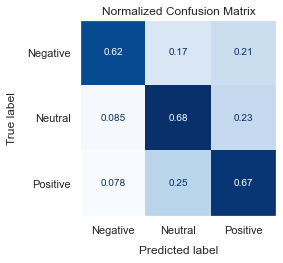

<IPython.core.display.Javascript object>

In [53]:
test_fit(main_pipe)

## Model Mark II

In [54]:
run_sweep = partial(
    sweep,
    X=X,
    y=y,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(5),
    random_state=rando,
)

<IPython.core.display.Javascript object>

In [55]:
filt_pipe = Pipeline([(f"f{i+1}", "passthrough") for i in range(8)])
text_pipe = Pipeline([("fil", filt_pipe), ("vec", tfidf)])
col_xform.set_params(txt=text_pipe)
col_xform

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 Pipeline(steps=[('fil',
                                                  Pipeline(steps=[('f1',
                                                                   'passthrough'),
                                                                  ('f2',
                                                                   'passthrough'),
                                                                  ('f3',
                                                                   'passthrough'),
                                                                  ('f4',
                                                                   'passthrough'),
                                                                  ('f5',
                                                                   'passthrough'),
                                                                  ('f6',
                      

<IPython.core.display.Javascript object>

In [56]:
grid = [
    [funcs.lowercase, "passthrough"],
    [funcs.strip_punct, "passthrough"],
    [funcs.uni2ascii, "passthrough"],
    [funcs.split_alphanum, "passthrough"],
    [funcs.strip_numeric, "passthrough"],
    [funcs.limit_repeats, "passthrough"],
    [funcs.strip_handles, "passthrough"],
    [funcs.strip_short, "passthrough"],
]

grid = pd.Series({f"f{i+1}": x for i, x in enumerate(grid)})
grid = grid.add_prefix("col__txt__fil__")

tfidf.set_params(lowercase=False, strip_accents=False)

# run_sweep(
#     main_pipe,
#     grid.to_dict(),
#     name="filts",
#     kind="hgrid",
#     cv=5,
#     min_resources=50,
#     factor=1.5,
#     random_state=rando,
# )

TfidfVectorizer(lowercase=False, strip_accents=False, token_pattern=None,
                tokenizer=<function casual_tokenize at 0x0000021A83C1A4C0>)

<IPython.core.display.Javascript object>

In [57]:
results = load_results("sweeps/filts.joblib")
results = results.applymap(
    lambda x: utils.get_func_name(x) if isinstance(x, FunctionTransformer) else x
)
results.mask(results == "passthrough").head(10)

,f1,f2,f3,f4,f5,f6,f7,f8,mean_score,rank_score
772,lowercase,strip_punct,uni2ascii,split_alphanum,strip_numeric,NaN,strip_handles,NaN,0.611921,1
770,lowercase,strip_punct,uni2ascii,split_alphanum,strip_numeric,limit_repeats,strip_handles,NaN,0.611077,2
771,lowercase,strip_punct,uni2ascii,NaN,strip_numeric,limit_repeats,strip_handles,NaN,0.609302,3
767,lowercase,strip_punct,uni2ascii,split_alphanum,strip_numeric,NaN,strip_handles,NaN,0.600375,4
769,lowercase,strip_punct,uni2ascii,NaN,strip_numeric,limit_repeats,strip_handles,NaN,0.599808,5
768,lowercase,strip_punct,uni2ascii,split_alphanum,strip_numeric,limit_repeats,strip_handles,NaN,0.599117,6
766,lowercase,strip_punct,NaN,split_alphanum,NaN,NaN,strip_handles,NaN,0.596775,7
158,NaN,strip_punct,uni2ascii,NaN,NaN,NaN,NaN,strip_short,0.587222,8
154,NaN,strip_punct,uni2ascii,NaN,NaN,limit_repeats,NaN,strip_short,0.587222,8
170,NaN,strip_punct,NaN,split_alphanum,NaN,limit_repeats,NaN,strip_short,0.587222,8


<IPython.core.display.Javascript object>

In [58]:
funcs = funcs.map(lambda x: x.func)
winners = [
    "lowercase",
    "strip_punct",
    "uni2ascii",
    "split_alphanum",
    "strip_numeric",
    "strip_handles",
]
chain_filts = partial(
    lang.chain_filts,
    filts=funcs.loc[winners].to_list(),
)
del text_pipe, filt_pipe, winners
col_xform.set_params(txt=tfidf, txt__preprocessor=chain_filts)

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 TfidfVectorizer(lowercase=False,
                                                 preprocessor=functools.partial(<function chain_filts at 0x0000021A863E2E50>, filts=[<function lowercase at 0x0000021A863E2310>, functools.partial(<function strip_punct at 0x0000021A863E2C10>, exclude='@#!?'), <function uni2ascii at 0x0000021A863E28B0>, <function split_alphanum at 0x0000021...021A863E24C0>, <function strip_handles at 0x0000021A863E2820>]),
                                                 strip_accents=False,
                                                 token_pattern=None,
                                                 tokenizer=<function casual_tokenize at 0x0000021A83C1A4C0>),
                                 'text'),
                                ('pos',
                                 TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000021A863E6040>),
                   

<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.322,0.817,0.602,0.580,0.714,0.680,0.653
recall,0.599,0.696,0.666,0.653,0.680,,
f1-score,0.419,0.751,0.632,0.601,0.691,,
support,0.064,0.605,0.332,,,,


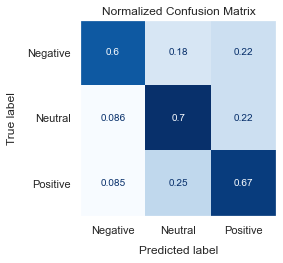

<IPython.core.display.Javascript object>

In [59]:
test_fit(main_pipe)

## Model Mark III

In [60]:
grid = pd.Series(
    dict(
        binary=[True, False],
        sublinear_tf=[True, False],
        smooth_idf=[True, False],
        norm=[None, "l1", "l2"],
        use_idf=[True, False],
    )
)
grid

binary           [True, False]
sublinear_tf     [True, False]
smooth_idf       [True, False]
norm            [None, l1, l2]
use_idf          [True, False]
dtype: object

<IPython.core.display.Javascript object>

In [61]:
# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__txt__"),
#     name="txt_tfidf",
#     cv=5,
#     kind="hgrid",
#     min_resources=1000,
#     factor=1.5,
#     random_state=rando,
# )

<IPython.core.display.Javascript object>

In [62]:
results = load_results("sweeps/txt_tfidf", drop_dicts=False)
results.head(3).drop("params", axis=1)

,binary,norm,smooth_idf,sublinear_tf,use_idf,mean_score,rank_score
128,False,l2,True,True,True,0.621419,1
131,False,l2,True,False,True,0.618498,2
127,False,l2,False,False,True,0.618030,3


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.318,0.818,0.600,0.579,0.714,0.678,0.653
recall,0.599,0.693,0.667,0.653,0.678,,
f1-score,0.416,0.750,0.632,0.599,0.690,,
support,0.064,0.605,0.332,,,,


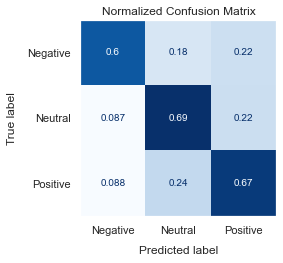

<IPython.core.display.Javascript object>

In [63]:
main_pipe.set_params(**results.iloc[0].params)
test_fit(main_pipe)

In [64]:
# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__pos__"),
#     name="pos_tfidf",
#     cv=5,
#     kind="hgrid",
#     factor=1.5,
#     min_resources=1000,
#     random_state=rando,
# )


<IPython.core.display.Javascript object>

In [65]:
results = load_results("sweeps/pos_tfidf", drop_dicts=False)
results.head().drop("params", axis=1)

,binary,norm,smooth_idf,sublinear_tf,use_idf,mean_score,rank_score
133,True,l1,False,False,False,0.623307,1
131,True,l1,True,False,False,0.623307,1
130,True,l1,True,True,False,0.623307,1
132,True,l1,False,True,False,0.623307,1
129,True,l1,True,False,True,0.621604,5


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.324,0.814,0.602,0.580,0.712,0.680,0.651
recall,0.592,0.698,0.663,0.651,0.680,,
f1-score,0.419,0.751,0.631,0.600,0.690,,
support,0.064,0.605,0.332,,,,


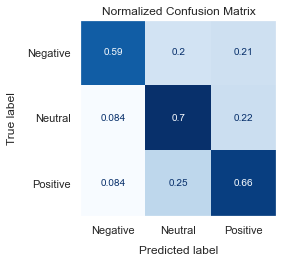

<IPython.core.display.Javascript object>

In [66]:
main_pipe.set_params(**results.params.iloc[0])
test_fit(main_pipe)

In [67]:
# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__bra__"),
#     name="bra_tfidf",
#     cv=5,
#     kind="hgrid",
#     factor=1.5,
#     min_resources=1000,
#     random_state=rando,
# )


<IPython.core.display.Javascript object>

In [68]:
results = load_results("sweeps/bra_tfidf", drop_dicts=False)
results.head().drop("params", axis=1)

,binary,norm,smooth_idf,sublinear_tf,use_idf,mean_score,rank_score
133,True,l1,False,True,False,0.630308,1
130,True,l1,True,True,False,0.630308,1
132,True,l1,False,False,False,0.630308,1
131,True,l1,True,False,False,0.630308,1
128,True,None,False,True,True,0.630065,5


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.329,0.815,0.600,0.582,0.713,0.680,0.653
recall,0.599,0.698,0.663,0.653,0.680,,
f1-score,0.425,0.752,0.630,0.602,0.691,,
support,0.064,0.605,0.332,,,,


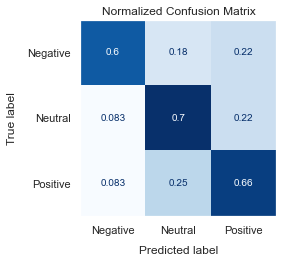

<IPython.core.display.Javascript object>

In [69]:
main_pipe.set_params(**results.params.iloc[0])
test_fit(main_pipe)

## Model Mark IV

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.292,0.826,0.598,0.572,0.716,0.667,0.661
recall,0.655,0.676,0.654,0.661,0.667,,
f1-score,0.404,0.743,0.624,0.591,0.682,,
support,0.064,0.605,0.332,,,,


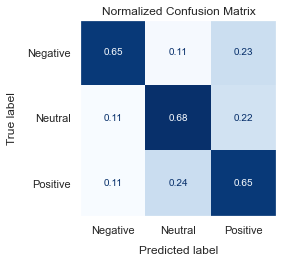

<IPython.core.display.Javascript object>

In [70]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("nrm", Normalizer("l2")),
        ("cls", logit),
    ]
)

test_fit(main_pipe)

In [73]:
grid = [
    dict(
        cls__C=np.geomspace(1e-4, 1, 5),
        cls__penalty=["l2"],
    ),
    dict(
        cls__C=[1],
        cls__penalty=["none"],
    ),
]

logit.set_params(max_iter=1e6, solver="lbfgs")

# run_sweep(
#     main_pipe,
#     grid,
#     name="penalty",
#     kind="hgrid",
#     min_resources=1000,
#     factor=3,
# )

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 8912
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 1000
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 3000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


'sweeps\\penalty.joblib'

<IPython.core.display.Javascript object>

In [75]:
results = load_results("sweeps/penalty", drop_dicts=False)
results.drop("params", axis=1)

,C,penalty,mean_score,rank_score
7,1.0,l2,0.584451,1
6,0.1,l2,0.519688,2
4,1.0,l2,0.491566,3
3,0.1,l2,0.474799,4
2,0.01,l2,0.474479,5
1,0.001,l2,0.474067,6
0,0.0001,l2,0.455689,7
5,1,none,0.434009,8


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.292,0.826,0.598,0.572,0.716,0.667,0.661
recall,0.655,0.676,0.654,0.661,0.667,,
f1-score,0.404,0.743,0.624,0.591,0.682,,
support,0.064,0.605,0.332,,,,


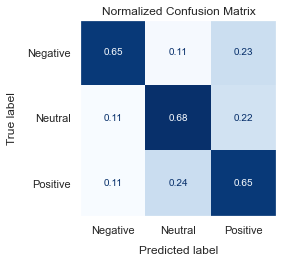

<IPython.core.display.Javascript object>

In [76]:
main_pipe.set_params(**results.iloc[0].params)
test_fit(main_pipe)

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.292,0.826,0.598,0.572,0.716,0.667,0.661
recall,0.655,0.676,0.654,0.661,0.667,,
f1-score,0.404,0.743,0.624,0.591,0.682,,
support,0.064,0.605,0.332,,,,


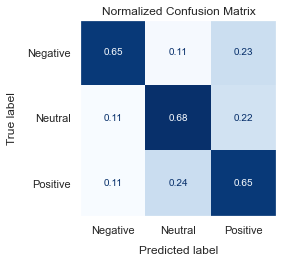

<IPython.core.display.Javascript object>

In [77]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("nrm", Normalizer("l2")),
        ("sel", VarianceThreshold(1e-6)),
        ("cls", logit),
    ]
)

test_fit(main_pipe)

In [78]:
grid = dict(
    ngram_range=utils.cartesian(1, np.arange(2, 10)).tolist(),
    analyzer=["char", "char_wb", "word"],
)
# grid = pd.Series(grid)
# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__txt__"),
#     name="ngram",
#     kind="hgrid",
#     min_resources="exhaust",
#     factor=3,
# )

<IPython.core.display.Javascript object>

In [79]:
results = load_results("sweeps/ngram")
results.head()

,analyzer,ngram_range,mean_score,rank_score
34,char_wb,"[1, 5]",0.634430,1
33,char_wb,"[1, 6]",0.634007,2
32,char_wb,"[1, 8]",0.632494,3
31,char_wb,"[1, 5]",0.567345,4
27,char_wb,"[1, 6]",0.566812,5


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.304,0.821,0.592,0.572,0.712,0.664,0.667
recall,0.683,0.670,0.650,0.667,0.664,,
f1-score,0.421,0.738,0.619,0.593,0.678,,
support,0.064,0.605,0.332,,,,


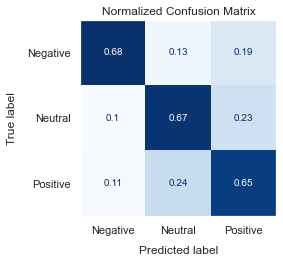

<IPython.core.display.Javascript object>

In [80]:
tfidf.set_params(ngram_range=(1, 5), analyzer="char_wb")
test_fit(main_pipe)

In [81]:
grid = pd.Series(
    dict(
        ngram_range=utils.cartesian(1, np.arange(1, 6)).tolist(),
        analyzer=["char", "char_wb", "word"],
    )
)

# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__pos__"),
#     name="pos_ngram",
#     kind="hgrid",
#     min_resources="exhaust",
#     factor=3,
# )

<IPython.core.display.Javascript object>

In [82]:
results = load_results("sweeps/pos_ngram")
results.head()

,analyzer,ngram_range,mean_score,rank_score
20,char,"[1, 2]",0.637870,1
21,word,"[1, 1]",0.634986,2
18,word,"[1, 1]",0.580892,3
16,char,"[1, 2]",0.570657,4
15,word,"[1, 3]",0.569725,5


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.311,0.818,0.585,0.571,0.708,0.660,0.668
recall,0.690,0.663,0.650,0.668,0.660,,
f1-score,0.429,0.732,0.615,0.592,0.674,,
support,0.064,0.605,0.332,,,,


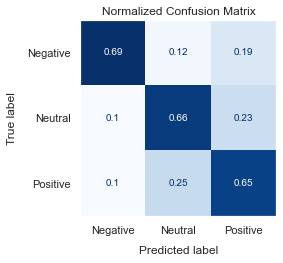

<IPython.core.display.Javascript object>

In [83]:
col_xform.set_params(pos__ngram_range=(1, 2), pos__analyzer="char")
test_fit(main_pipe)

In [84]:
results = load_results("sweeps/bra_ngram")
results.head()

,analyzer,ngram_range,mean_score,rank_score
21,char,"[1, 1]",0.637794,1
20,char_wb,"[1, 1]",0.636731,2
18,char,"[1, 1]",0.586830,3
16,char_wb,"[1, 1]",0.585330,4
19,word,"[1, 1]",0.583999,5


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.349,0.806,0.598,0.584,0.708,0.675,0.669
recall,0.669,0.690,0.650,0.669,0.675,,
f1-score,0.459,0.743,0.623,0.608,0.685,,
support,0.064,0.605,0.332,,,,


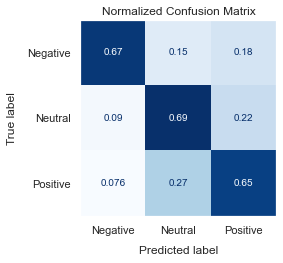

<IPython.core.display.Javascript object>

In [85]:
col_xform.set_params(bra__analyzer="char")
test_fit(main_pipe)

In [86]:
grid = pd.Series(dict(threshold=np.arange(1, 10, 1) * 1e-6))
# run_sweep(
#     main_pipe,
#     grid.add_prefix("sel__"),
#     name="var_thresh",
#     kind="grid",
# )

<IPython.core.display.Javascript object>

In [87]:
results = load_results("sweeps/var_thresh")
results.head()

,threshold,mean_score,rank_score
5,0.000006,0.641513,1
4,0.000005,0.640812,2
3,0.000004,0.640199,3
6,0.000007,0.640056,4
2,0.000003,0.639302,5


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.325,0.813,0.597,0.578,0.710,0.668,0.674
recall,0.697,0.676,0.648,0.674,0.668,,
f1-score,0.443,0.738,0.622,0.601,0.681,,
support,0.064,0.605,0.332,,,,


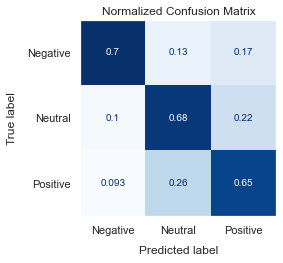

<IPython.core.display.Javascript object>

In [88]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("nrm", Normalizer("l2")),
        ("sel", VarianceThreshold(6e-6)),
        ("cls", logit),
    ]
)

test_fit(main_pipe)